Epoch 1/100
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0743 - val_loss: 0.0146
Epoch 2/100
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0088 - val_loss: 0.0097
Epoch 3/100
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 4/100
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0079 - val_loss: 0.0102
Epoch 5/100
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0071 - val_loss: 0.0097
Epoch 6/100
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0070 - val_loss: 0.0098
Epoch 7/100
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0067 - val_loss: 0.0106
Epoch 8/100
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0064 - val_loss: 0.0080
Epoch 9/100
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0065 - val_loss: 0.0091
Epoch 10/100
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0060 - val_loss: 0.0082
Epoch 11/100
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 12/10

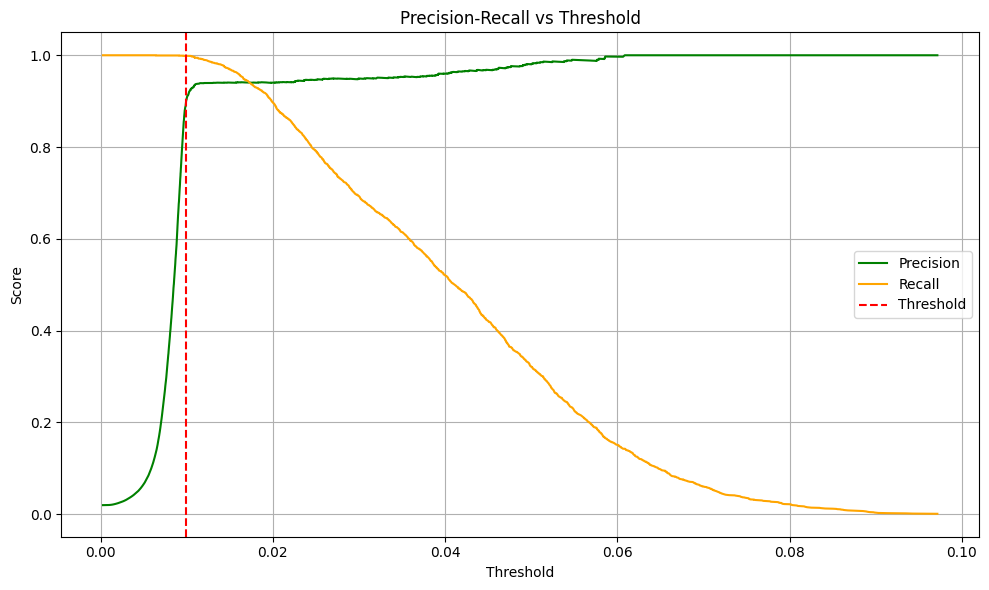

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score,64 f1_score, precision_recall_curve
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# === Load Dataset ===
file_path = "cpu_memory_data_augmented.csv"
df = pd.read_csv(file_path)

# === Prepare features and labels ===
X = df.drop(columns=["timestamp", "is_anomaly"])  # Drop timestamp and label
y = df["is_anomaly"]

# === Handle missing values ===
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# === Split into train/test sets ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Use only normal data (label == 0) for training
X_train_normal = X_train[y_train == 0]

# === Build Deep Autoencoder ===
input_dim = X_train_normal.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(128, activation="relu")(input_layer)
encoded = Dense(64, activation="relu")(encoded)
encoded = Dense(16, activation="relu")(encoded)

# Decoder
decoded = Dense(64, activation="relu")(encoded)
decoded = Dense(128, activation="relu")(decoded)
output_layer = Dense(input_dim, activation="linear")(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mae")

# === Train Autoencoder ===
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1
)

# === Predict Reconstruction Error ===
reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test - reconstructed), axis=1)

# === Select Threshold Based on Precision ≥ 90% ===
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, reconstruction_error)

selected_threshold = None
for p, r, t in zip(precision_vals, recall_vals, thresholds):
    if p >= 0.90:
        selected_threshold = t
        break

if selected_threshold is None:
    selected_threshold = np.percentile(reconstruction_error, 99.9)  # fallback

# === Predict Anomalies ===
y_pred = (reconstruction_error > selected_threshold).astype(int)

# === Evaluation ===
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n📊 Autoencoder (Test Set Metrics with Optimized Threshold):")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print(f"F1 Score:  {f1 * 100:.2f}%")
print(f"Selected Threshold: {selected_threshold:.6f}")

# === Plot Precision-Recall vs Threshold ===
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_vals[:-1], label='Precision', color='green')
plt.plot(thresholds, recall_vals[:-1], label='Recall', color='orange')
plt.axvline(selected_threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet

# === Load the dataset ===
file_path = "cpu_memory_data_augmented.csv"
df = pd.read_csv(file_path)

# === Check for ground truth column ===
if "is_anomaly" not in df.columns:
    raise ValueError("Ground truth column 'is_anomaly' is missing in the dataset.")

# === Preprocess ===
numeric_df = df.drop(columns=["timestamp", "is_anomaly"])
true_labels = df["is_anomaly"]

# === Standardize the features ===
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# === Robust Covariance Estimation ===
mcd = MinCovDet().fit(scaled_data)
robust_mean = mcd.location_
robust_cov_inv = np.linalg.inv(mcd.covariance_)

# === Mahalanobis distances ===
distances = np.array([
    mahalanobis(x, robust_mean, robust_cov_inv)
    for x in scaled_data
])

# === Thresholding (tune multiplier to increase precision) ===
threshold = distances.mean() + 2.5 * distances.std()
pred_labels = (distances > threshold).astype(int)

# === Metrics ===
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print("📊 Mahalanobis Distance Metrics:")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print(f"F1 Score:  {f1 * 100:.2f}%")

# === View sample anomalies ===
print("\nSample detected anomalies:")
print(df[pred_labels == 1].head())

# === Optional: Save to file ===
# df[pred_labels == 1].to_csv("robust_mahalanobis_anomalies.csv", index=False)


📊 Mahalanobis Distance Metrics:
Precision: 91.01%
Recall:    73.09%
F1 Score:  81.07%

Sample detected anomalies:
                     timestamp  cpu_utilization  memory_usage  req_served  \
35        2024-03-11T20:00:08Z        41.000000     70.000000  447.000000   
103       2024-03-02T15:00:03Z        50.000000     40.000000  202.000000   
136  2024-03-15 04:49:57+00:00        46.787416     24.380732  471.666081   
256  2024-03-15 04:46:56+00:00        23.397844     35.280503  218.919719   
272  2024-03-15 04:43:06+00:00        31.351938     38.069039  315.218059   

     bytes_transferred  is_anomaly  
35       816100.000000           1  
103      604000.000000           0  
136      645403.089155           1  
256      525003.914923           1  
272      632901.629342           1  


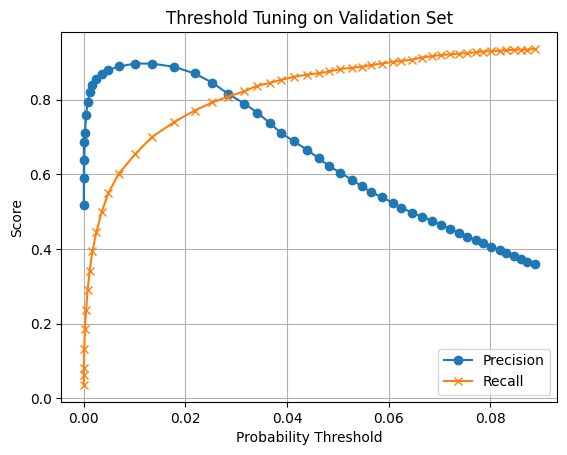

📊 Final Multivariate Gaussian (No PCA, Tuned Threshold):
Optimal Threshold Used: 0.010085085958281455
Precision: 90.99%
Recall:    67.21%
F1 Score:  77.31%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    109850
           1       0.91      0.67      0.77      2150

    accuracy                           0.99    112000
   macro avg       0.95      0.84      0.88    112000
weighted avg       0.99      0.99      0.99    112000



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# === Load and prepare data ===
df = pd.read_csv("cpu_memory_data_augmented.csv")
X = df.drop(columns=["timestamp", "is_anomaly"])
y = df["is_anomaly"]

# === Train-validation-test split ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# === Gaussian Model ===
mean = np.mean(X_train_scaled, axis=0)
cov = np.cov(X_train_scaled, rowvar=False)
dist = multivariate_normal(mean=mean, cov=cov)

val_probs = dist.pdf(X_val_scaled)
test_probs = dist.pdf(X_test_scaled)

# === Threshold tuning on validation set ===
thresholds = np.percentile(val_probs, np.linspace(0.1, 5, 50))  # try multiple low percentiles
best_precision = 0
best_threshold = None

precisions = []
recalls = []

for threshold in thresholds:
    y_pred_val = (val_probs < threshold).astype(int)
    prec = precision_score(y_val, y_pred_val, zero_division=0)
    rec = recall_score(y_val, y_pred_val)
    precisions.append(prec)
    recalls.append(rec)

    if prec > best_precision:
        best_precision = prec
        best_threshold = threshold

# === Plot for visualization ===
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='x')
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning on Validation Set")
plt.legend()
plt.grid(True)
plt.show()

# === Final prediction on test set ===
y_pred_final = (test_probs < best_threshold).astype(int)

# === Metrics ===
precision = precision_score(y_test, y_pred_final) * 100
recall = recall_score(y_test, y_pred_final) * 100
f1 = f1_score(y_test, y_pred_final) * 100

print("📊 Final Multivariate Gaussian (No PCA, Tuned Threshold):")
print(f"Optimal Threshold Used: {best_threshold}")
print(f"Precision: {precision:.2f}%")
print(f"Recall:    {recall:.2f}%")
print(f"F1 Score:  {f1:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# === Load the augmented dataset ===
df = pd.read_csv("cpu_memory_data_augmented.csv")

# === Prepare features and labels ===
X = df.drop(columns=["timestamp", "is_anomaly"])
y = df["is_anomaly"]

# === Train-test split (Stratified to preserve anomaly ratio) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Standardize features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Train Random Forest ===
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train_scaled, y_train)

# === Predict ===
y_pred = clf.predict(X_test_scaled)

# === Evaluation ===
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n📊 Random Forest Evaluation on Augmented Dataset:")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print(f"F1 Score:  {f1 * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



📊 Random Forest Evaluation on Augmented Dataset:
Precision: 100.00%
Recall:    98.74%
F1 Score:  99.37%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    109850
           1       1.00      0.99      0.99      2150

    accuracy                           1.00    112000
   macro avg       1.00      0.99      1.00    112000
weighted avg       1.00      1.00      1.00    112000



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from hdbscan import HDBSCAN

# Load the updated dataset with added anomalies
df = pd.read_csv("cpu_memory_data_augmented.csv")

# Separate features and label
X = df.drop(columns=["timestamp", "is_anomaly"])
y = df["is_anomaly"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit HDBSCAN
hdb = HDBSCAN(min_cluster_size=15, min_samples=1, prediction_data=True)
hdb.fit(X_scaled)

# Get cluster labels (-1 indicates anomalies)
labels = hdb.labels_
y_pred = np.where(labels == -1, 1, 0)

# Evaluate the results
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print("📊 HDBSCAN (Unsupervised) Metrics:")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print(f"F1 Score:  {f1 * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📊 HDBSCAN (Unsupervised) Metrics:
Precision: 92.12%
Recall:    35.65%
F1 Score:  51.40%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    549248
           1       0.92      0.36      0.51     10752

    accuracy                           0.99    560000
   macro avg       0.95      0.68      0.75    560000
weighted avg       0.99      0.99      0.98    560000



In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

# === Load dataset ===
df = pd.read_csv("cpu_memory_data_augmented.csv")

# === Prepare features and labels ===
X = df.drop(columns=["timestamp", "is_anomaly"])
y = df["is_anomaly"]

# === Split dataset ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Scale features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === PCA fit and transform ===
n_components = 2  # You can increase this if needed
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_train_reconstructed = pca.inverse_transform(X_train_pca)

# === Train reconstruction error threshold on train set ===
reconstruction_error_train = np.mean((X_train_scaled - X_train_reconstructed) ** 2, axis=1)
threshold = np.percentile(reconstruction_error_train, 98)  # Top 2% will be anomalies

# === Test set PCA reconstruction ===
X_test_pca = pca.transform(X_test_scaled)
X_test_reconstructed = pca.inverse_transform(X_test_pca)
reconstruction_error_test = np.mean((X_test_scaled - X_test_reconstructed) ** 2, axis=1)

# === Predict anomalies based on reconstruction error ===
y_pred = (reconstruction_error_test > threshold).astype(int)

# === Evaluation ===
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100

print("📊 PCA Anomaly Detection Metrics:")
print(f"Precision: {precision:.2f}%")
print(f"Recall:    {recall:.2f}%")
print(f"F1 Score:  {f1:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


📊 PCA Anomaly Detection Metrics:
Precision: 91.89%
Recall:    94.37%
F1 Score:  93.12%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    109850
           1       0.92      0.94      0.93      2150

    accuracy                           1.00    112000
   macro avg       0.96      0.97      0.96    112000
weighted avg       1.00      1.00      1.00    112000



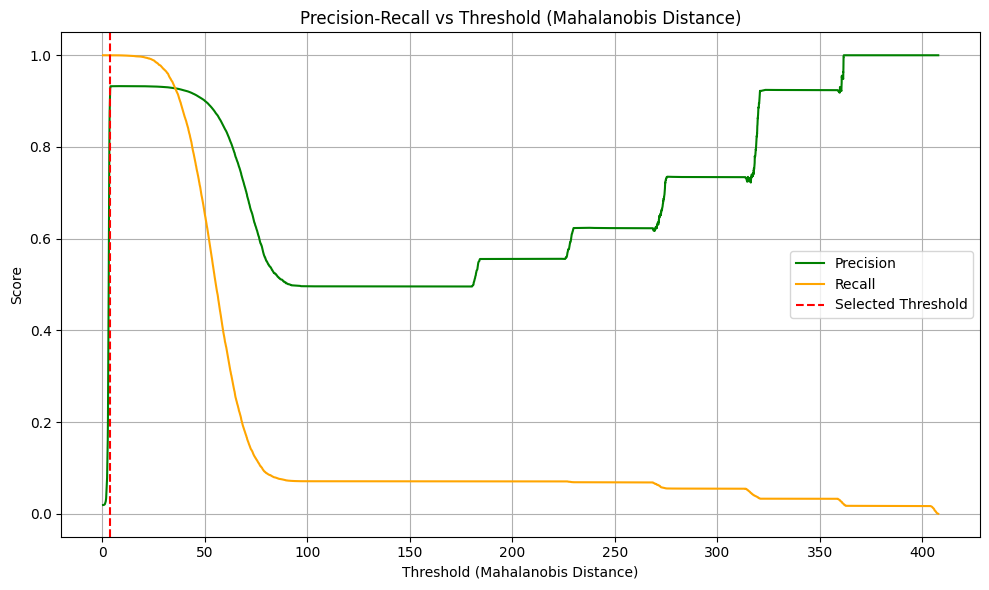


📊 Optimized Threshold Metrics (Precision ≥ 90%):
Precision: 90.04%
Recall:    100.00%
F1 Score:  94.76%
Selected Threshold: 3.6815


In [ ]:
from sklearn.metrics import precision_recall_curve

# Generate precision-recall data
precision_vals, recall_vals, thresholds = precision_recall_curve(true_labels, distances)

# Pick a threshold where precision ≥ 90% (like your autoencoder setup)
selected_threshold = None
for p, r, t in zip(precision_vals, recall_vals, thresholds):
    if p >= 0.90:
        selected_threshold = t
        break

# Fallback if none meet the requirement
if selected_threshold is None:
    selected_threshold = np.percentile(distances, 99.5)

# Predict using this threshold
pred_labels_opt = (distances > selected_threshold).astype(int)

# Plot precision-recall vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_vals[:-1], label='Precision', color='green')
plt.plot(thresholds, recall_vals[:-1], label='Recall', color='orange')
plt.axvline(selected_threshold, color='red', linestyle='--', label='Selected Threshold')
plt.xlabel("Threshold (Mahalanobis Distance)")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold (Mahalanobis Distance)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Recompute metrics at selected threshold
precision = precision_score(true_labels, pred_labels_opt)
recall = recall_score(true_labels, pred_labels_opt)
f1 = f1_score(true_labels, pred_labels_opt)

print("\n📊 Optimized Threshold Metrics (Precision ≥ 90%):")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print(f"F1 Score:  {f1 * 100:.2f}%")
print(f"Selected Threshold: {selected_threshold:.4f}")


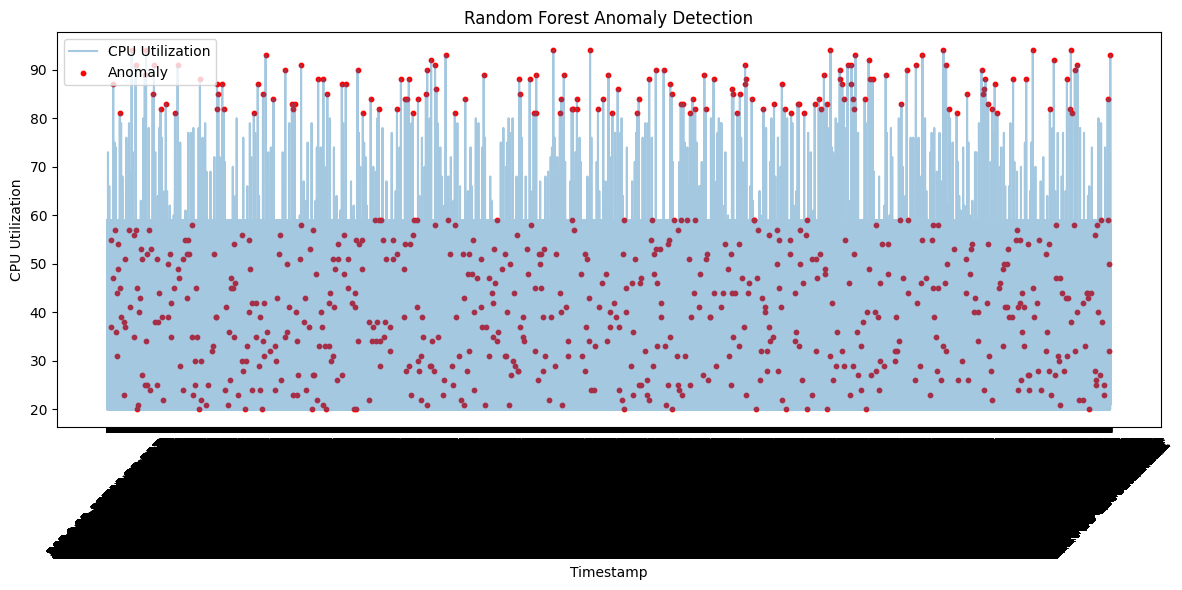

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/cpu_memory_data_with_anomalies.csv')
X = df.drop(['timestamp', 'is_anomaly'], axis=1)
y = df['is_anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
df['pred_rf'] = clf.predict(X)

plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df['cpu_utilization'], label='CPU Utilization', alpha=0.4)
plt.scatter(df['timestamp'][df['pred_rf'] == 1], df['cpu_utilization'][df['pred_rf'] == 1], color='red', label='Anomaly', s=10)
plt.legend()
plt.title("Random Forest Anomaly Detection")
plt.xlabel("Timestamp")
plt.ylabel("CPU Utilization")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 600.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.6 MB/s eta 0:00:00
